<a href="https://colab.research.google.com/github/Vincent-AIM/INSPECT/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Exploration

Read the data from `csv` files.

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import tempfile
from pathlib import Path

# Ensure torchvision is installed (for colab only)
# %pip install torchvision 

# PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

# nifti image processing libraries
import nibabel as nib

# azure storage libraries (for colab only)
# !pip install azure_storage_blob 
from azure.storage.blob import BlobServiceClient

# sklearn libraries (for data preprocessing)
from skimage.transform import resize  # Example for resizing
from sklearn.preprocessing import MinMaxScaler  # Example for normalization




In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

2.3.0+cu121
False
No GPU found


In [3]:
# Azure Blob Storage details
service_endpoint = "https://aimistanforddatasets01.blob.core.windows.net"
container_name = "inspect2"
sas_token = "sv=2019-02-02&sr=c&sig=Lq%2FVRyfleYbJDZp3vAQHFfuX1LhBKDwfaWY1tQvHz1w%3D&st=2024-12-18T14%3A16%3A05Z&se=2025-01-17T14%3A21%3A05Z&sp=rl"
ctpa_folder = "CTPA/"

In [4]:
# Use for colab only
# url = 'https://raw.githubusercontent.com/Vincent-AIM/INSPECT/refs/heads/main/Final_Impressions_labels.csv?token=GHSAT0AAAAAAC3UZFDFNIMT54RIEINRHZGUZ3NBXXA'
# df = pd.read_csv(url, encoding='unicode_escape')
df = pd.read_csv('Final_Impressions_labels.csv')
# print first 5 rows
print(f'there are {df.shape[0]} and {df.shape[1]} columns in the dataset')
df.head()

there are 23248 and 11 columns in the dataset


,impression_id,1_month_mortality,6_month_mortality,12_month_mortality,1_month_readmission,6_month_readmission,12_month_readmission,12_month_PH,pe_acute,pe_subsegmentalonly,pe_positive
0,PE4524142,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,0,0,0
1,PE9f5ca7,FALSE,Censored,Censored,FALSE,Censored,Censored,Censored,0,0,0
2,PE45267b4,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,0,0,0
3,PE452484d,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,0,0,0
4,PE4529e91,FALSE,TRUE,TRUE,FALSE,Censored,Censored,Censored,0,0,0


In [5]:
# Initialize the BlobServiceClient
blob_service_client = BlobServiceClient(account_url=service_endpoint, credential=sas_token)
container_client = blob_service_client.get_container_client(container_name)

In [6]:
# Check for invalid/corupted nifti files
invalid_files = [blob.name for blob in container_client.list_blobs(name_starts_with=ctpa_folder) if not blob.name.endswith('.gz')]
print(len(invalid_files))
print(invalid_files)


8
['CTPA/PE45241fd.nii.gz_.gstmp', 'CTPA/PE45283bf.nii.gz_.gstmp', 'CTPA/PE452890e.nii.gz_.gstmp', 'CTPA/PE45295ec.nii.gz_.gstmp', 'CTPA/PE876fb7.nii.gz_.gstmp', 'CTPA/PE87cf6e.nii.gz_.gstmp', 'CTPA/PE9f310c.nii.gz_.gstmp', 'CTPA/PE9f749e.nii.gz_.gstmp']


In [7]:
# Get the id of the nifti files
invalid_scan_id = [Path(files).stem.split('.')[0] for files in invalid_files]
print(invalid_scan_id)

['PE45241fd', 'PE45283bf', 'PE452890e', 'PE45295ec', 'PE876fb7', 'PE87cf6e', 'PE9f310c', 'PE9f749e']


In [8]:
# Remove records with invalid scans from the labels dataset
valid_df = df[~df['impression_id'].isin(invalid_scan_id)]
df.shape, valid_df.shape

((23248, 11), (23240, 11))

In [9]:
df = valid_df

### 1.1 Data Types and Null Values Check

Run the next cell to explore the data types present in each column and whether any null values exist in the data.

In [10]:
# Look at the data type of each column and whether null values are present
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23240 entries, 0 to 23247
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   impression_id         23240 non-null  object
 1   1_month_mortality     23240 non-null  object
 2   6_month_mortality     23240 non-null  object
 3   12_month_mortality    23240 non-null  object
 4   1_month_readmission   23240 non-null  object
 5   6_month_readmission   23240 non-null  object
 6   12_month_readmission  23240 non-null  object
 7   12_month_PH           23240 non-null  object
 8   pe_acute              23240 non-null  int64 
 9   pe_subsegmentalonly   23240 non-null  int64 
 10  pe_positive           23240 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 2.1+ MB


In [11]:
# check for NaN values in each column
print(df.isnull().any())

impression_id           False
1_month_mortality       False
6_month_mortality       False
12_month_mortality      False
1_month_readmission     False
6_month_readmission     False
12_month_readmission    False
12_month_PH             False
pe_acute                False
pe_subsegmentalonly     False
pe_positive             False
dtype: bool


### 1.2 Unique IDs Check

"impression_id" has an identification number for each patient's scan. One thing you'd like to know about a medical dataset like this is if you're looking at repeated data for certain patients or whether each image represents a different person.

In [12]:
print(f"the total scans are {df['impression_id'].count()}, from those the unique ids are {df['impression_id'].value_counts().shape[0]}")

the total scans are 23240, from those the unique ids are 23240


### 1.3 Data Labels
list of the names of patients' condition or disease.

In [13]:
columns = df.keys()
to_remove_cols = ['impression_id', '1_month_mortality', '6_month_mortality', '12_month_mortality', '1_month_readmission', '6_month_readmission', '12_month_readmission', '12_month_PH']
columns = list(columns)
print(columns)

['impression_id', '1_month_mortality', '6_month_mortality', '12_month_mortality', '1_month_readmission', '6_month_readmission', '12_month_readmission', '12_month_PH', 'pe_acute', 'pe_subsegmentalonly', 'pe_positive']


In [14]:
# Remove unnecesary elements
updated_cols = list(set(columns) - set(to_remove_cols))
# Get the total classes
print(f"There are {len(updated_cols)} columns of labels for these conditions: {updated_cols}")

There are 3 columns of labels for these conditions: ['pe_acute', 'pe_positive', 'pe_subsegmentalonly']


In [15]:
# Print out the number of positive labels for each class
for column in updated_cols:
    print(f"The class {column} has {df[column].sum()} samples")

The class pe_acute has 4069 samples
The class pe_positive has 4686 samples
The class pe_subsegmentalonly has 963 samples


In [16]:
# The number of scan that is pe_positive and of type acute
num_pos_acute = len(df[(df['pe_positive'] == 1) & (df['pe_acute'] == 1)])
num_pos_acute

4068

In [17]:
# The number of scan without pe
num_not_pe = len(df[(df['pe_positive'] == 0)])
num_not_pe

18554

In [18]:
# The number of scan with pe
num_pe = len(df[(df['pe_positive'] == 1)])
num_pe

4686

In [19]:
# Check for null
df.columns[df.isna().any()].tolist()

[]

In [20]:
# The number of scan that is pe_positive and of type subsegmentalonly
num_pos_subsegmental = len(df[(df['pe_positive'] == 1) & (df['pe_subsegmentalonly'] == 1)])
num_pos_subsegmental

955

### 1.4 Data Visualization

Using the image names listed in the csv file, you can retrieve the image associated with each row of data in your dataframe.

Run the cell below to visualize a random selection of images from the dataset.

/tmp/ipykernel_3585/1226043742.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'class', data = pe_positive_data, palette = "Set1",  edgecolor = "black")


<Axes: xlabel='class', ylabel='count'>

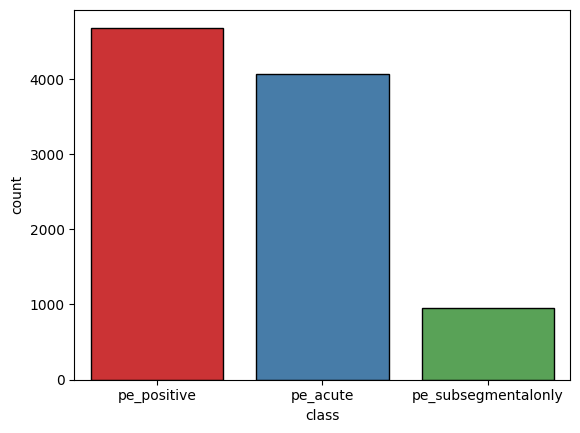

In [21]:
pe_positive_data = pd.DataFrame(np.concatenate([['pe_positive'] *  num_pe, ['pe_acute'] * num_pos_acute, ['pe_subsegmentalonly'] * num_pos_subsegmental]), columns = ["class"])

sns.countplot(x = 'class', data = pe_positive_data, palette = "Set1",  edgecolor = "black")

/tmp/ipykernel_3585/664224398.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'class', data = pe_data, palette = "Set1",  edgecolor = "black")


<Axes: xlabel='class', ylabel='count'>

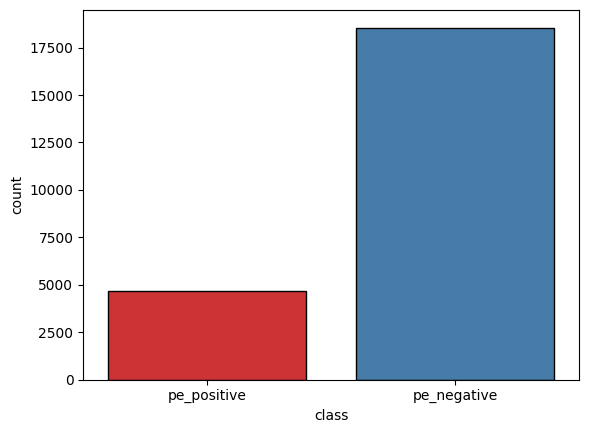

In [22]:
pe_data = pd.DataFrame(np.concatenate([['pe_positive'] *  num_pe, ['pe_negative'] * num_not_pe]), columns = ["class"])

sns.countplot(x = 'class', data = pe_data, palette = "Set1",  edgecolor = "black")

In [23]:
# Right now the dataset is not balanced in terms of the number of positive and negative pe samples.
# We will balance the dataset by sampling with replacement
balanced_df = pd.concat([df[df['pe_positive'] == 1], df[df['pe_positive'] == 0].sample(n = num_pe, replace = True)], axis = 0)
DF_train = df.groupby(['pe_positive']).apply(lambda x: x.sample(num_pe, replace = True)
                                                      ).reset_index(drop = True)

print(f"the balanced dataset has {balanced_df.shape[0]} samples")
print('New Data Size:', DF_train.shape[0])


the balanced dataset has 9372 samples
New Data Size: 9372


/tmp/ipykernel_3585/2734057194.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  DF_train = df.groupby(['pe_positive']).apply(lambda x: x.sample(num_pe, replace = True)


In [24]:
balanced_num_pos_acute = len(balanced_df[(balanced_df['pe_positive'] == 1) & (balanced_df['pe_acute'] == 1)])
balanced_num_pos_subsegmental = len(balanced_df[(balanced_df['pe_positive'] == 1) & (balanced_df['pe_subsegmentalonly'] == 1)])
balanced_num_pe = len(balanced_df[(balanced_df['pe_positive'] == 1)])
balanced_num_not_pe = len(balanced_df[(balanced_df['pe_positive'] == 0)])

/tmp/ipykernel_3585/882643575.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'class', data = balanced_data, palette = "Set1",  edgecolor = "black")


<Axes: xlabel='class', ylabel='count'>

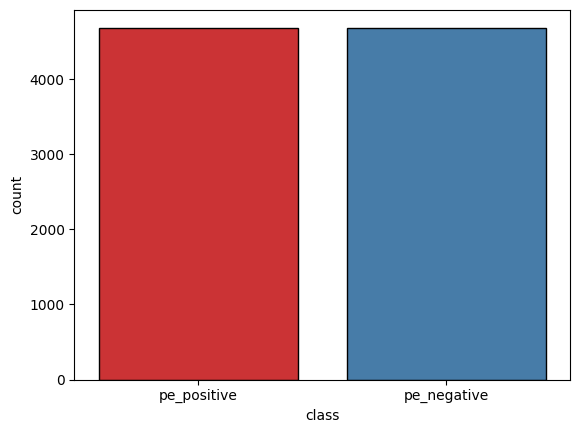

In [25]:
balanced_data = pd.DataFrame(np.concatenate([['pe_positive'] *  balanced_num_pe, ['pe_negative'] * balanced_num_not_pe]), columns = ["class"])
sns.countplot(x = 'class', data = balanced_data, palette = "Set1",  edgecolor = "black")

/tmp/ipykernel_3585/1347739185.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'class', data = balanced_pos_data, palette = "Set1",  edgecolor = "black")


<Axes: xlabel='class', ylabel='count'>

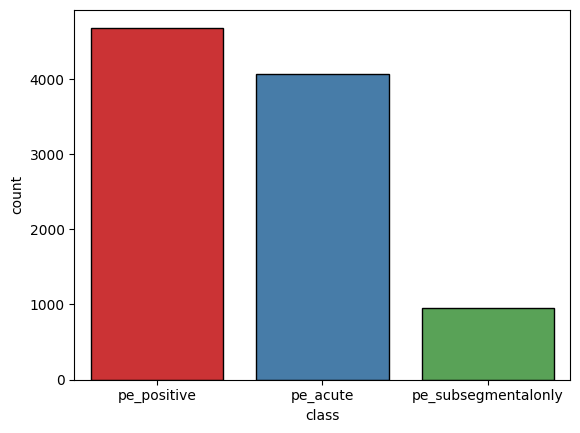

In [26]:
balanced_pos_data = pd.DataFrame(np.concatenate([['pe_positive'] *  balanced_num_pe, ['pe_acute'] * balanced_num_pos_acute, ['pe_subsegmentalonly'] * balanced_num_pos_subsegmental]), columns = ["class"])
sns.countplot(x = 'class', data = balanced_pos_data, palette = "Set1",  edgecolor = "black")

# Creation of Dataset and Dataloader

In [27]:
# Azure Blob Storage details
# service_endpoint = "https://aimistanforddatasets01.blob.core.windows.net"
# container_name = "inspect2"
# sas_token = "sv=2019-02-02&sr=c&sig=Lq%2FVRyfleYbJDZp3vAQHFfuX1LhBKDwfaWY1tQvHz1w%3D&st=2024-12-18T14%3A16%3A05Z&se=2025-01-17T14%3A21%3A05Z&sp=rl"
# ctpa_folder = "CTPA/"

In [28]:
# Initialize the BlobServiceClient
# blob_service_client = BlobServiceClient(account_url=service_endpoint, credential=sas_token)
# container_client = blob_service_client.get_container_client(container_name)

In [29]:
# Check for invalid/corupted nifti files
# invalid_files = [blob.name for blob in container_client.list_blobs(name_starts_with=ctpa_folder) if not blob.name.endswith('.gz')]
# print(len(invalid_files))
# print(invalid_files)


In [30]:

# Custom Dataset class for loading NIfTI images
class InspectDataset(Dataset):
    def __init__(self, img_data, container_client, folder_name):
        self.container_client = container_client
        self.folder_name = folder_name
        self.img_data = img_data

    def __len__(self):
        # Return the total number of NIfTI files in the folder
        return len(self.img_data)

    def __getitem__(self, idx):
        # Get the NIfTI file for the given index
        impression_id = self.img_data.iloc[idx]['impression_id']
        blob_name = os.path.join(self.folder_name, f"{impression_id}.nii.gz")
        # print(blob_name)
        try:
            # Download the blob data as a stream
            blob_client = self.container_client.get_blob_client(blob_name)
            blob_stream = blob_client.download_blob()
            blob_data = blob_stream.readall()

            # Create a temporary file for the blob
            with tempfile.NamedTemporaryFile(suffix=".nii.gz", delete=False) as temp_file:
                temp_file.write(blob_data)
                temp_file.flush()
                temp_filename = temp_file.name

            # Load the NIfTI file from the temporary file
                nifti_image = nib.load(temp_filename)
                image_data = nifti_image.get_fdata()

                # --- Data Preparation ---
                # Example 1: Resize to a target shape
                resized_data = resize(image_data, output_shape=(128, 128, 128), mode='constant', preserve_range=True)

                # Example 2: Normalize to [0, 1]
                scaler = MinMaxScaler()
                normalized_data = scaler.fit_transform(resized_data.reshape(-1, 1)).reshape(resized_data.shape)

            # Convert image data to float32 tensor and normalize if needed
            image_tensor = torch.tensor(normalized_data, dtype=torch.float32)
            image_tensor = image_tensor.unsqueeze(0)  # Add channel dimension

            # Get the label for the image
            label = torch.tensor(self.img_data.iloc[idx]['pe_positive'])

            # Ensure the temporary file is removed
            if os.path.exists(temp_filename):
                os.remove(temp_filename)

            # If you have labels, you can modify this to return a tuple (image_tensor, label)
            return image_tensor, label

        except Exception as e:
            print(f"Error processing blob {blob_name}: {e}")
            return None


In [31]:
# Create Dataset instance
inspect_dataset = InspectDataset(balanced_df, container_client, ctpa_folder)

In [32]:
print(len(inspect_dataset))

9372


In [33]:
x,y = inspect_dataset[0]
x

tensor([[[[0.0567, 0.0466, 0.0466,  ..., 0.0474, 0.0474, 0.0574],
          [0.0581, 0.0477, 0.0478,  ..., 0.0813, 0.0805, 0.0885],
          [0.2003, 0.1968, 0.1972,  ..., 0.2140, 0.2138, 0.2174],
          ...,
          [0.0424, 0.0306, 0.0299,  ..., 0.0304, 0.0318, 0.0427],
          [0.0430, 0.0316, 0.0310,  ..., 0.0336, 0.0334, 0.0437],
          [0.0613, 0.0510, 0.0512,  ..., 0.0526, 0.0526, 0.0618]],

         [[0.0388, 0.0278, 0.0277,  ..., 0.0386, 0.0384, 0.0480],
          [0.1116, 0.1039, 0.1041,  ..., 0.1626, 0.1634, 0.1662],
          [0.2078, 0.2050, 0.2066,  ..., 0.1663, 0.1670, 0.1723],
          ...,
          [0.0183, 0.0064, 0.0072,  ..., 0.0070, 0.0080, 0.0195],
          [0.0178, 0.0055, 0.0051,  ..., 0.0078, 0.0077, 0.0203],
          [0.0420, 0.0321, 0.0316,  ..., 0.0330, 0.0324, 0.0428]],

         [[0.0655, 0.0535, 0.0533,  ..., 0.0977, 0.0982, 0.1043],
          [0.2036, 0.1995, 0.1998,  ..., 0.2193, 0.2208, 0.2204],
          [0.1376, 0.1327, 0.1333,  ..., 0

In [34]:
type(x), x.dtype, x.shape

(torch.Tensor, torch.float32, torch.Size([1, 128, 128, 128]))

In [35]:
y

tensor(1)

In [36]:
len_train = int(0.8*len(inspect_dataset))
len_val = len(inspect_dataset) - len_train
train, Val = torch.utils.data.random_split(inspect_dataset, [len_train, len_val], generator=torch.Generator().manual_seed(42))

In [37]:
len(train), len(Val)

(7497, 1875)

# Validation Dataset

In [38]:

# Custom Dataset class for loading NIfTI images
class InspectValset(Dataset):
    def __init__(self, img_data, container_client, folder_name):
        self.container_client = container_client
        self.folder_name = folder_name
        self.img_data = img_data

    def __len__(self):
        # Return the total number of NIfTI files in the folder
        return len(self.img_data)

    def __getitem__(self, idx):
        # Get the NIfTI file for the given index
        impression_id = self.img_data.iloc[idx]['impression_id']
        blob_name = os.path.join(self.folder_name, f"{impression_id}.nii.gz")
        # print(blob_name)
        try:
            # Download the blob data as a stream
            # blob_client = self.container_client.get_blob_client(blob.name)
            blob_client = self.container_client.get_blob_client(blob_name)
            blob_stream = blob_client.download_blob()
            blob_data = blob_stream.readall()

            # Create a temporary file for the blob
            with tempfile.NamedTemporaryFile(suffix=".nii.gz", delete=False) as temp_file:
                temp_file.write(blob_data)
                temp_file.flush()
                temp_filename = temp_file.name

            # Load the NIfTI file from the temporary file
                nifti_image = nib.load(temp_filename)
                image_data = nifti_image.get_fdata()

                # --- Data Preparation ---
                # Example 1: Resize to a target shape
                resized_data = resize(image_data, output_shape=(128, 128, 128), mode='constant', preserve_range=True)



            # Convert image data to float32 tensor and normalize if needed
            image_tensor = torch.tensor(resized_data, dtype=torch.float32)

            # Get the label for the image
            label = torch.tensor(self.img_data.iloc[idx]['pe_positive'])

            # Ensure the temporary file is removed
            if os.path.exists(temp_filename):
                os.remove(temp_filename)

            # If you have labels, you can modify this to return a tuple (image_tensor, label)
            return image_tensor, label

        except Exception as e:
            print(f"Error processing blob {blob_name}: {e}")
            return None


In [39]:
# check if dataset is balanced
# pe_positive = 0
# for i in range(len(Val)):
#     x, y = Val[i]
#     if y ==1:
#         pe_positive += 1
# print(pe_positive/len(Val))

In [40]:
train_loader = DataLoader(train, batch_size=2, shuffle=False, drop_last=True)
Val_loader = DataLoader(Val, batch_size=2)


# Creation of Dataset and Visualization

In [41]:
dataset_visual = InspectDataset(balanced_df, container_client, ctpa_folder)
train_visual, Val_visual = torch.utils.data.random_split(dataset_visual, [len_train, len_val], generator=torch.Generator().manual_seed(42))

/tmp/ipykernel_3585/3618563346.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  axes[i].imshow(slice.T, cmap="gray", origin="lower")


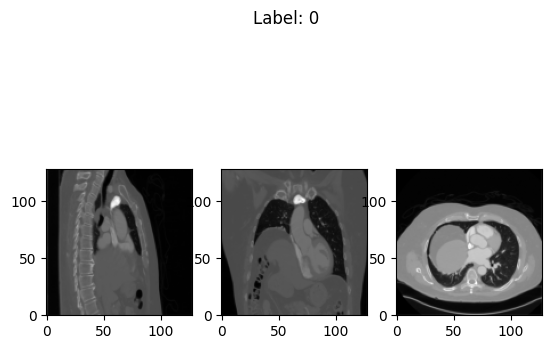

In [42]:
def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

# Get the first image tensor and show the slices
image_tensor, label = train_visual[0]
show_slices([image_tensor[:,64], image_tensor[:,:, 64], image_tensor[:,:, :, 64]])
plt.suptitle(f"Label: {label}")
plt.show()

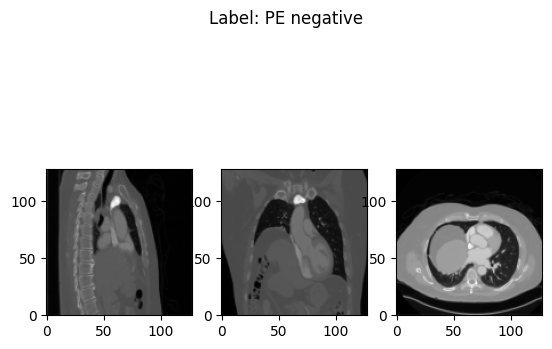

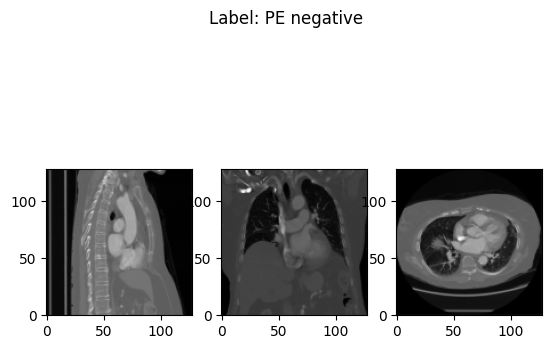

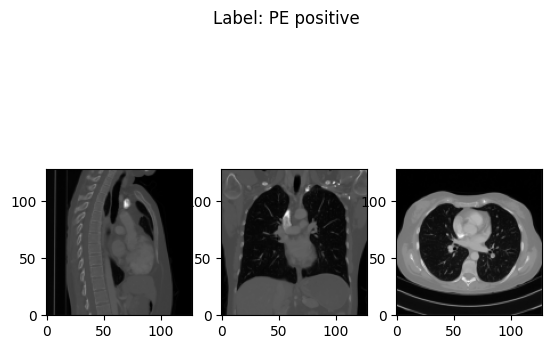

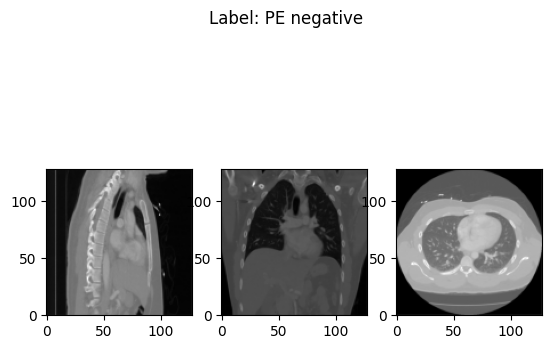

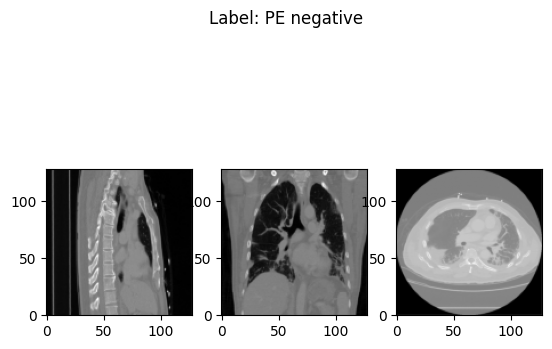

In [43]:
# Dictionary for labels
arthopod_types = {0: 'PE negative', 1: 'PE positive'}

# Viewing data examples used for training
for i in range(5):
    with torch.no_grad():
        image, label = train_visual[i]

        # Display the middle slices along the three axes
        middle_slices = [
            image[:, image.shape[1] // 2, :, :],  # Middle slice along the first axis
            image[:, :, image.shape[2] // 2, :],  # Middle slice along the second axis
            image[:, :, :, image.shape[3] // 2]   # Middle slice along the third axis
        ]

        # Show the slices
        show_slices(middle_slices)
        plt.suptitle(f"Label: {arthopod_types[label.item()]}")
        plt.show()


In [44]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Define the max pooling layer
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)

        # Define Flatten layer
        self.flatten = nn.Flatten()

        # Define the fully connected layers
        self.fc1 = nn.Linear(32 * 32 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

        # Define dropout layer
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Apply the convolutional layers
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # print(x.shape)
        # Flatten the output for the fully connected layers
        x = self.flatten(x)

        # Apply the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1048576, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


: 

In [ ]:
test_model = SimpleCNN()
test_data = torch.randn(2, 1, 128, 128, 128)
test_output = test_model(test_data)
print(test_output)

In [92]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
n_epochs = 10
valid_loss_min = np.inf
Val_loss = []
Val_acc = []
train_loss = []
train_acc = []
# total_step = len(train_loader)
total_step = 40
# training
for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total=0
    print(f"Epoch {epoch}\n")
    for batch_idx, (data_, target_) in enumerate(train_loader):
        # limit each epoch to 40 batches only (for testing purpose only)
        if batch_idx * train_loader.batch_size > total_step:
            break
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()

        outputs = model(data_)
        loss = criterion(outputs, target_.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred == target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for batch_idx, (data_t, target_t) in enumerate(Val_loader):
            # limit each epoch to 40 batches only (for testing purpose only)
            if batch_idx * train_loader.batch_size > total_step:
                break
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t.unsqueeze(1).float())
            batch_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t == target_t).item()
            total_t += target_t.size(0)
        # Val_loss.append(batch_loss/len(Val_loader))
        Val_loss.append(batch_loss/total_step)
        Val_acc.append(100 * correct_t / total_t)
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(Val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        # Saving the best weight
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model.pt')
            print('Detected network improvement, saving current model')
    scheduler.step()

Epoch 1

Epoch [1/10], Step [0/3751], Loss: 0.7311
Epoch [1/10], Step [20/3751], Loss: 0.5397
Epoch [1/10], Step [40/3751], Loss: 0.7373
Epoch [1/10], Step [60/3751], Loss: 0.6490
Epoch [1/10], Step [80/3751], Loss: 0.6932
Epoch [1/10], Step [100/3751], Loss: 0.6915
